# Instructions: 
1. For feature selections, run generate_train_test(*lag*, *weekly/monthly/daily*, *datasets used*) to generate training and testing dataset 
2. Uncomment .tocsv lines in the function to transform training and testing df to csv files.
3. Refer to last line of code for example

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.linear_model import LinearRegression

In [2]:
# datasets chosen - tech companies
df_aapl = pd.read_csv('../datasets/stocks/AAPL.csv')
df_ggl = pd.read_csv('../datasets/stocks/GOOGL.csv')
df_msft = pd.read_csv('../datasets/stocks/MSFT.csv')

Text(0, 0.5, 'Close Price')

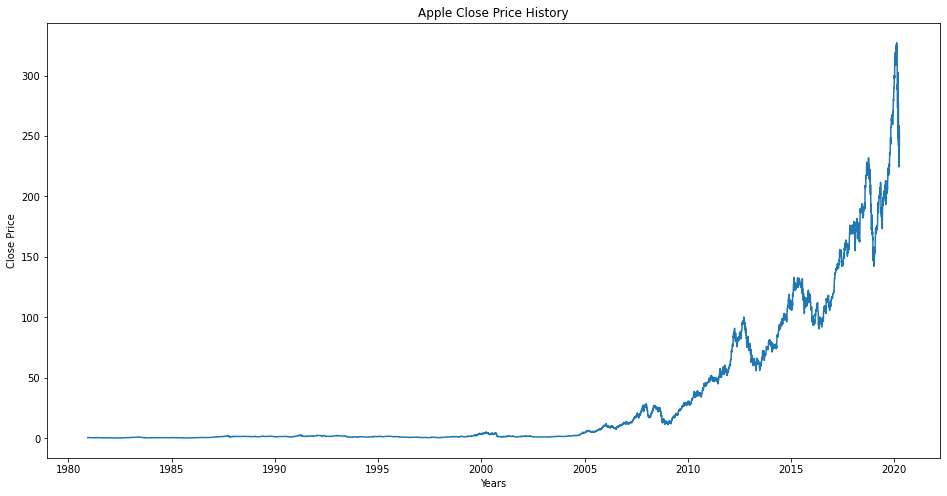

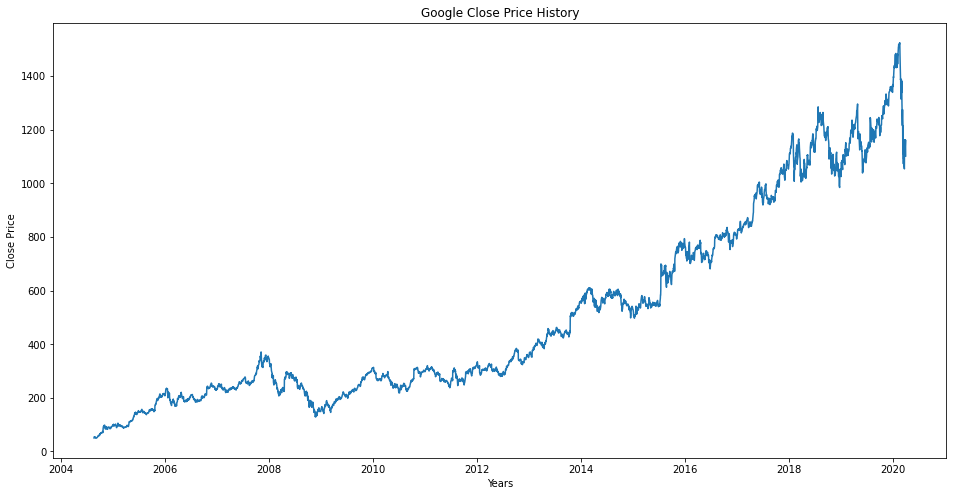

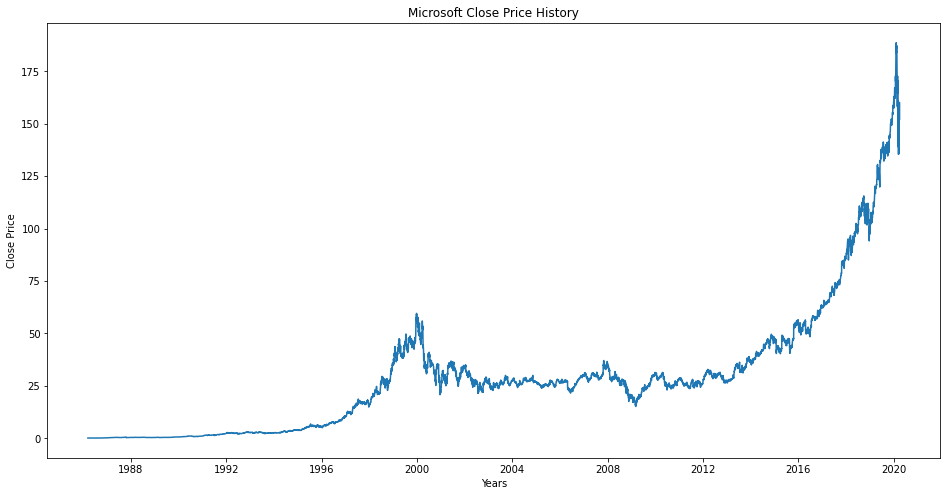

In [3]:
# apple
df_aapl['Date'] = pd.to_datetime(df_aapl.Date,format='%Y-%m-%d')
df_aapl.index = df_aapl['Date']
plt.figure(figsize=(16,8))
plt.plot(df_aapl['Close'])
plt.title("Apple Close Price History")
plt.xlabel("Years")
plt.ylabel("Close Price")

# google
df_ggl['Date'] = pd.to_datetime(df_ggl.Date,format='%Y-%m-%d')
df_ggl.index = df_ggl['Date']
plt.figure(figsize=(16,8))
plt.plot(df_ggl['Close'])
plt.title("Google Close Price History")
plt.xlabel("Years")
plt.ylabel("Close Price")

# microsoft
df_msft['Date'] = pd.to_datetime(df_msft.Date,format='%Y-%m-%d')
df_msft.index = df_msft['Date']
plt.figure(figsize=(16,8))
plt.plot(df_msft['Close'])
plt.title("Microsoft Close Price History")
plt.xlabel("Years")
plt.ylabel("Close Price")

In [4]:
def split(df):
    train_size = round(len(df)*0.7)
    y_movement = df['movement']
    y_t = df['Close (t)']
    X_colnames = df.drop(['Close (t)', 'movement'], axis=1).columns
    X = df[X_colnames]

    # for movement
    X_train, X_test, y_train_movement, y_test_movement = X[:train_size], X[train_size:], y_movement[:train_size], y_movement[train_size:]

    # for t
    X_train, X_test, y_train_t, y_test_t = X[:train_size], X[train_size:], y_t[:train_size], y_t[train_size:]
    train_df = pd.concat([X_train,y_train_t,y_train_movement],axis = 1)
    test_df = pd.concat([X_test,y_test_t, y_test_movement],axis = 1)
    return train_df, test_df

In [5]:
def shift(df, n):
    new_df = pd.DataFrame()
    # volume
    vol = "Volume (t-"+str(n)+")"
    new_df[vol] = df['Volume']
    for i in range(n-1,0,-1):
        v = "Volume (t-"+str(i)+")"
        new_df[v] = df['Volume'].shift(-(n-i))

    # close price
    p = "Close (t-"+str(n)+")"
    new_df[p] = df['Close']
    for i in range(n-1,0,-1):
        v = "Close (t-"+str(i)+")"
        new_df[v] = df['Close'].shift(-(n-i))

    # y-variable (close price)
    new_df['Close (t)'] = df['Close'].shift(-n)
    new_df = new_df.dropna()

    # y-variable (movement)
    new_df['movement'] = np.where(new_df["Close (t)"] > new_df['Close (t-1)'], 1, 0)
    return new_df


In [6]:
# Automate pipeline to generate training and testing datasets based on lag
def generate_train_test(lag, avg = "weekly", *datasets):
    """
    Return the training and testing dataset, uncomment to transform df to csv after feature selections
    """
    train_all = pd.DataFrame()
    test_all = pd.DataFrame()
    for df in datasets:
        if avg == "weekly":
            df = df.resample('W').mean()
        elif avg == "monthly":
            df = df.resample('M').mean()
        #else, daily, noneed groupby
        df = shift(df, lag)
        train_df, test_df = split(df)
        train_all = pd.concat([train_all, train_df])
        test_all = pd.concat([test_all, test_df])
    #train_all.to_csv(str(lag)+"_"+avg+"_train.csv")
    #test_all.to_csv(str(lag)+"_"+avg+"_test.csv")
    return train_all, test_all


In [7]:
# Remove data where price stagnant
df_aapl = df_aapl[(df_aapl['Date'] >= '2005-01-01')]
df_msft = df_msft[(df_msft['Date'] >= '1998-01-01')]

## Linear Regression on Stock

In [8]:
def linear_regression(name, df_stock, lag, aggr_fun='weekly'):
    train_stock, test_stock = generate_train_test(lag, aggr_fun, df_stock)

    model_stock = LinearRegression()
    x_train_stock = train_stock.drop(['Close (t)', 'movement'], axis=1)
    y_train_stock = train_stock['Close (t)']
    model_stock.fit(x_train_stock, y_train_stock)

    # features should exclude 'movement' and 'Close (t)'
    x_test_stock = test_stock.drop(['Close (t)', 'movement'], axis=1)
    y_test_stock = test_stock['Close (t)']

    preds_stock = model_stock.predict(x_test_stock)
    rms_stock = np.sqrt(np.mean(np.power((np.array(y_test_stock)-np.array(preds_stock)),2)))

    print(name, aggr_fun.capitalize(), 'RMS:', rms_stock)

    # plot
    df_results = pd.DataFrame()
    df_results[name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)'] = test_stock['Close (t)']
    df_results[name+' '+aggr_fun.capitalize()+' Price Prediction'] = preds_stock

    plt.plot(df_results[name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)'])
    plt.plot(df_results[name+' '+aggr_fun.capitalize()+' Price Prediction'])

    plt.title(name+' '+aggr_fun.capitalize()+' with sliding window '+str(lag))
    
    plt.ylabel('Close',fontsize=18)
    plt.legend([name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)', name+' '+aggr_fun.capitalize()+' Price Prediction'])
    plt.show()

    move_test_stock = test_stock['movement']

    pred_move_stock = (preds_stock - test_stock["Close (t-1)"]) 
    pred_move_stock = pred_move_stock.where(pred_move_stock<0, 1).where(pred_move_stock>=0, 0).astype(int)

    precision = precision_score(move_test_stock, pred_move_stock)
    recall = recall_score(move_test_stock, pred_move_stock)
    accuracy = accuracy_score(move_test_stock, pred_move_stock)
    f1 = f1_score(move_test_stock, pred_move_stock)
    
    print(confusion_matrix(move_test_stock, pred_move_stock))
    print('Precision: %.3f' % precision)
    print('Recall: %.3f' % recall)
    print('Accuracy: %.3f' % accuracy)
    print('F1-score: %.3f\n' % f1)
    
    return rms_stock, precision, recall, accuracy, f1_score
    

## Compare between Models

### Apple

Apple Weekly RMS: 5.268114187519139


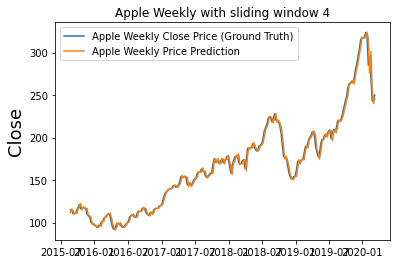

[[53 40]
 [46 99]]
Precision: 0.712
Recall: 0.683
Accuracy: 0.639
F1-score: 0.697



(5.268114187519139,
 0.7122302158273381,
 0.6827586206896552,
 0.6386554621848739,
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>)

In [9]:
# ~ one month lag
linear_regression(name='Apple', df_stock=df_aapl, lag=4)

Apple Weekly RMS: 5.3013461400744


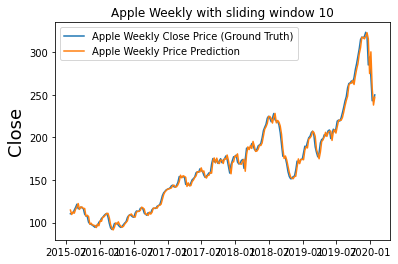

[[46 46]
 [50 94]]
Precision: 0.671
Recall: 0.653
Accuracy: 0.593
F1-score: 0.662



(5.3013461400744,
 0.6714285714285714,
 0.6527777777777778,
 0.5932203389830508,
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>)

In [10]:
linear_regression(name='Apple', df_stock=df_aapl, lag=10)

Apple Weekly RMS: 5.341107495559539


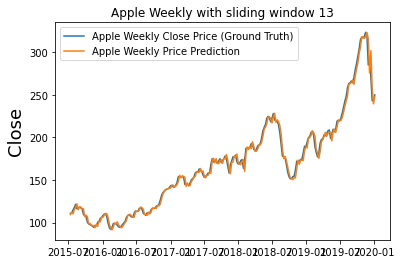

[[49 42]
 [54 90]]
Precision: 0.682
Recall: 0.625
Accuracy: 0.591
F1-score: 0.652



(5.341107495559539,
 0.6818181818181818,
 0.625,
 0.5914893617021276,
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>)

In [11]:
# ~ one quarter
linear_regression(name='Apple', df_stock=df_aapl, lag=13)

Apple Weekly RMS: 5.38828180983019


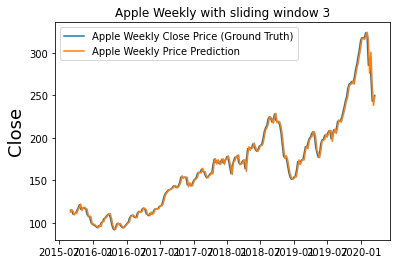

[[ 46  47]
 [ 40 105]]
Precision: 0.691
Recall: 0.724
Accuracy: 0.634
F1-score: 0.707



(5.38828180983019,
 0.6907894736842105,
 0.7241379310344828,
 0.634453781512605,
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>)

In [12]:
linear_regression(name='Apple', df_stock=df_aapl, lag=3)

4 weeks (one month) > 13 weeks > 10 weeks

## Google

Google Weekly RMS: 28.114451194250588


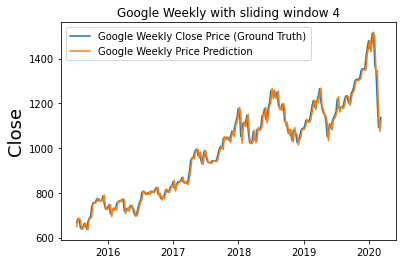

[[63 37]
 [72 72]]
Precision: 0.661
Recall: 0.500
Accuracy: 0.553
F1-score: 0.569



(28.114451194250588,
 0.6605504587155964,
 0.5,
 0.5532786885245902,
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>)

In [13]:
linear_regression(name='Google', df_stock=df_ggl, lag=4)

Google Weekly RMS: 28.249874413412883


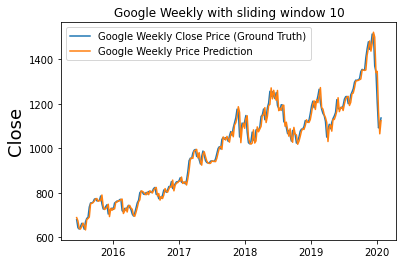

[[54 46]
 [61 81]]
Precision: 0.638
Recall: 0.570
Accuracy: 0.558
F1-score: 0.602



(28.249874413412883,
 0.6377952755905512,
 0.5704225352112676,
 0.5578512396694215,
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>)

In [14]:
linear_regression(name='Google', df_stock=df_ggl, lag=10)

Google Weekly RMS: 28.35547044643911


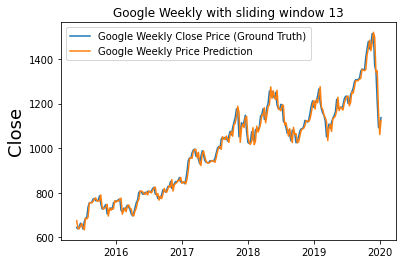

[[58 41]
 [64 78]]
Precision: 0.655
Recall: 0.549
Accuracy: 0.564
F1-score: 0.598



(28.35547044643911,
 0.6554621848739496,
 0.5492957746478874,
 0.5643153526970954,
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>)

In [15]:
linear_regression(name='Google', df_stock=df_ggl, lag=13)

## Microsoft

Microsoft Weekly RMS: 2.827443949566443


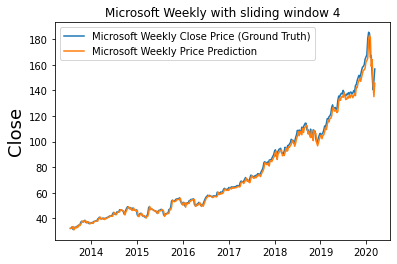

[[125   9]
 [199  14]]
Precision: 0.609
Recall: 0.066
Accuracy: 0.401
F1-score: 0.119



(2.827443949566443,
 0.6086956521739131,
 0.06572769953051644,
 0.40057636887608067,
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>)

In [16]:
linear_regression(name='Microsoft', df_stock=df_msft, lag=4)

Microsoft Weekly RMS: 2.640265503869841


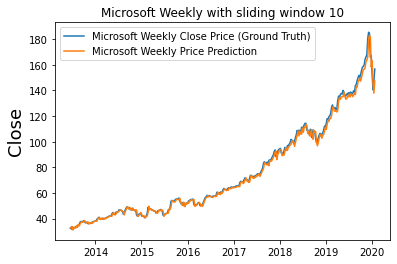

[[109  25]
 [174  38]]
Precision: 0.603
Recall: 0.179
Accuracy: 0.425
F1-score: 0.276



(2.640265503869841,
 0.6031746031746031,
 0.1792452830188679,
 0.42485549132947975,
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>)

In [17]:
linear_regression(name='Microsoft', df_stock=df_msft, lag=10)

Microsoft Weekly RMS: 2.6440730093381903


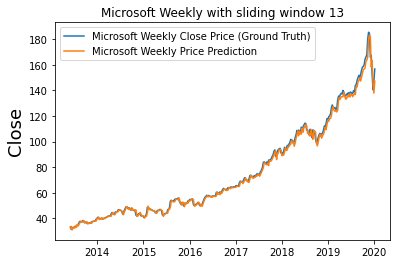

[[110  24]
 [176  35]]
Precision: 0.593
Recall: 0.166
Accuracy: 0.420
F1-score: 0.259



(2.6440730093381903,
 0.5932203389830508,
 0.16587677725118483,
 0.42028985507246375,
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>)

In [18]:
linear_regression(name='Microsoft', df_stock=df_msft, lag=13)

Microsoft Daily RMS: 1.726925635784874


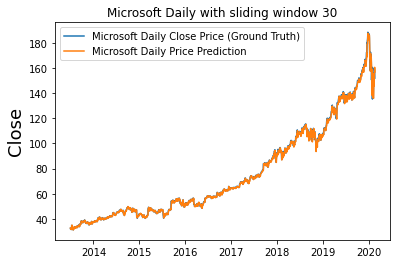

[[647 134]
 [734 155]]
Precision: 0.536
Recall: 0.174
Accuracy: 0.480
F1-score: 0.263



(1.726925635784874,
 0.5363321799307958,
 0.17435320584926883,
 0.4802395209580838,
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>)

In [19]:
linear_regression(name='Microsoft', df_stock=df_msft, lag=30, aggr_fun='daily')

Microsoft Daily RMS: 1.7189803138055428


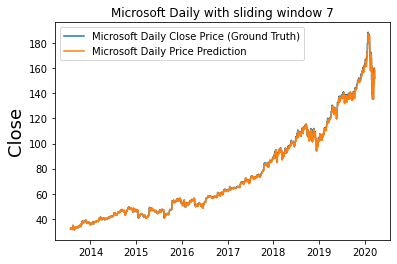

[[726  59]
 [828  64]]
Precision: 0.520
Recall: 0.072
Accuracy: 0.471
F1-score: 0.126



(1.7189803138055428,
 0.5203252032520326,
 0.07174887892376682,
 0.4710793082886106,
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>)

In [20]:
linear_regression(name='Microsoft', df_stock=df_msft, lag=7, aggr_fun='daily')

## Plot against performance & lag

In [21]:
def linear_regression_clean(name, df_stock, lag, aggr_fun='weekly'):
    train_stock, test_stock = generate_train_test(lag, aggr_fun, df_stock)

    model_stock = LinearRegression()
    x_train_stock = train_stock.drop(['Close (t)', 'movement'], axis=1)
    y_train_stock = train_stock['Close (t)']
    model_stock.fit(x_train_stock, y_train_stock)

    # features should exclude 'movement' and 'Close (t)'
    x_test_stock = test_stock.drop(['Close (t)', 'movement'], axis=1)
    y_test_stock = test_stock['Close (t)']

    preds_stock = model_stock.predict(x_test_stock)
    rms_stock = np.sqrt(np.mean(np.power((np.array(y_test_stock)-np.array(preds_stock)),2)))

    # plot
    df_results = pd.DataFrame()
    df_results[name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)'] = test_stock['Close (t)']
    df_results[name+' '+aggr_fun.capitalize()+' Price Prediction'] = preds_stock

    move_test_stock = test_stock['movement']

    pred_move_stock = (preds_stock - test_stock["Close (t-1)"]) 
    pred_move_stock = pred_move_stock.where(pred_move_stock<0, 1).where(pred_move_stock>=0, 0).astype(int)

    precision = precision_score(move_test_stock, pred_move_stock)
    recall = recall_score(move_test_stock, pred_move_stock)
    accuracy = accuracy_score(move_test_stock, pred_move_stock)
    f1 = f1_score(move_test_stock, pred_move_stock)
    
    return rms_stock, precision, recall, accuracy, f1_score
    

In [22]:
def plot_lag_to_performance(name, df_stock, aggr_fun='weekly'):
    rmss = []
    precisions = []
    recalls = []
    accuracies = []
    f1_scores = []

    lag_range = [i for i in range(1, 32)]
    
    # get performance df
    for i in lag_range:
        rms_stock, precision, recall, accuracy, f1_score = linear_regression_clean(name, df_stock, i, aggr_fun='weekly')
        rmss.append(rms_stock)
        precisions.append(precision)
        recalls.append(recall)
        accuracies.append(accuracy)
        f1_scores.append(f1_score)

    performances_arr = np.transpose(np.array([rmss, precisions, recalls, accuracies, f1_scores]))
    per_str = ['rmss', 'precisions', 'recalls', 'accuracies', 'f1_scores']
    df_perform = pd.DataFrame(data=performances_arr, index=lag_range, columns=per_str)
    
    # plotting performance against lag
    values = df_perform.values
    groups = range(0,4)
    i = 1
    plt.figure()
    for group in groups:
        plt.subplot(len(groups), 1, i)
        plt.plot(values[:, group])
        plt.title(df_perform.columns[group], y=0.5, loc='right')
        i += 1
    plt.show()
    
    return df_perform

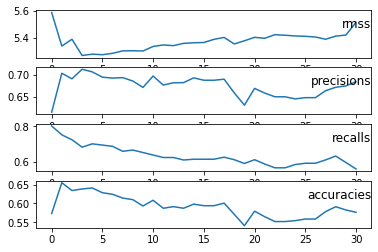

In [23]:
df_perform_aapl = plot_lag_to_performance(name='Apple', df_stock=df_aapl)

In [24]:
df_perform_aapl  # 4 (1 month)

,rmss,precisions,recalls,accuracies,f1_scores
1,5.587052,0.615789,0.80137,0.573222,<function f1_score at 0x0000016493D149D0>
2,5.338191,0.703226,0.751724,0.655462,<function f1_score at 0x0000016493D149D0>
3,5.388282,0.690789,0.724138,0.634454,<function f1_score at 0x0000016493D149D0>
4,5.268114,0.71223,0.682759,0.638655,<function f1_score at 0x0000016493D149D0>
5,5.277974,0.706294,0.701389,0.64135,<function f1_score at 0x0000016493D149D0>
6,5.273838,0.694444,0.694444,0.628692,<function f1_score at 0x0000016493D149D0>
7,5.284192,0.692308,0.6875,0.624473,<function f1_score at 0x0000016493D149D0>
8,5.302232,0.693431,0.659722,0.614407,<function f1_score at 0x0000016493D149D0>
9,5.30326,0.685714,0.666667,0.610169,<function f1_score at 0x0000016493D149D0>
10,5.301346,0.671429,0.652778,0.59322,<function f1_score at 0x0000016493D149D0>


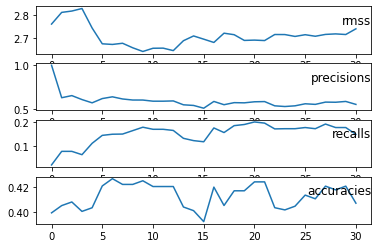

In [25]:
df_perform_msft = plot_lag_to_performance(name='Microsoft', df_stock=df_msft)

In [26]:
df_perform_msft  # 7 (2 months?), generally lowest

,rmss,precisions,recalls,accuracies,f1_scores
1,2.759626,1.0,0.023364,0.399425,<function f1_score at 0x0000016493D149D0>
2,2.810554,0.62963,0.079439,0.405172,<function f1_score at 0x0000016493D149D0>
3,2.816391,0.653846,0.079439,0.408046,<function f1_score at 0x0000016493D149D0>
4,2.827444,0.608696,0.065728,0.400576,<function f1_score at 0x0000016493D149D0>
5,2.742523,0.571429,0.112676,0.403458,<function f1_score at 0x0000016493D149D0>
6,2.673693,0.62,0.14554,0.420749,<function f1_score at 0x0000016493D149D0>
7,2.670958,0.64,0.150235,0.426513,<function f1_score at 0x0000016493D149D0>
8,2.676074,0.615385,0.150943,0.421965,<function f1_score at 0x0000016493D149D0>
9,2.656405,0.603448,0.165094,0.421965,<function f1_score at 0x0000016493D149D0>
10,2.640266,0.603175,0.179245,0.424855,<function f1_score at 0x0000016493D149D0>


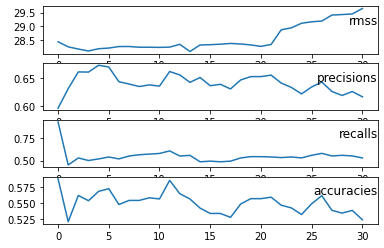

In [27]:
df_perform_ggl = plot_lag_to_performance(name='Google', df_stock=df_ggl)

In [28]:
df_perform_ggl # 12 (around a quarter)

,rmss,precisions,recalls,accuracies,f1_scores
1,28.447004,0.596413,0.923611,0.587755,<function f1_score at 0x0000016493D149D0>
2,28.263378,0.631068,0.451389,0.520492,<function f1_score at 0x0000016493D149D0>
3,28.184181,0.66087,0.527778,0.561475,<function f1_score at 0x0000016493D149D0>
4,28.114451,0.66055,0.5,0.553279,<function f1_score at 0x0000016493D149D0>
5,28.195893,0.672727,0.517483,0.567901,<function f1_score at 0x0000016493D149D0>
6,28.219431,0.669565,0.538462,0.572016,<function f1_score at 0x0000016493D149D0>
7,28.274459,0.643478,0.517483,0.547325,<function f1_score at 0x0000016493D149D0>
8,28.276236,0.639344,0.549296,0.553719,<function f1_score at 0x0000016493D149D0>
9,28.249643,0.634921,0.56338,0.553719,<function f1_score at 0x0000016493D149D0>
10,28.249874,0.637795,0.570423,0.557851,<function f1_score at 0x0000016493D149D0>
